# Using Google Big Transfer (BiT) to generate Image Embeddings

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import PIL
from numpy.linalg import norm
import torchvision as tv


from PIL import *
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from src.resnetv2 import ResNetV2, get_headless_model, get_model_weights
from src.img_preprocessing import preprocess_eval, tobaccoDataSet

Big Transfer for image embeddings set-up

In [4]:
# First we download the model weights for BiT-M trained on Imagenet 21k
weights = get_model_weights('BiT-M-R50x1')
# We set up BiT-M with the Imagenet 21k output size number of classes
model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=21843) 
# Reload the model weights 
model.load_from(weights)
# Get final layer prior to classification layer in head
tf_last_layer_chopped = get_headless_model(model)
# Print the model architecture
tf_last_layer_chopped

Sequential(
  (0): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (padp): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (block1): Sequential(
      (unit01): PreActBottleneck(
        (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (gn3): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (downsample): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (unit02): PreActBottleneck(
        (gn1): GroupNorm(32, 256, eps=1e-05, affine

Initiate the [Tobacco 800](http://tc11.cvc.uab.es/datasets/Tobacco800_1) Dataset

In [5]:
tobacco_dataset = tobaccoDataSet("/home/jovyan/work/BiT-Tobacco-800/data/Tobacco800_SinglePage/SinglePageTIF",
                                           transform=preprocess_eval)
loader_test = torch.utils.data.DataLoader(tobacco_dataset, batch_size=50, shuffle=False)

In [6]:
tf_last_layer_chopped.eval()

output = []
with torch.no_grad():
    for i, x in enumerate(loader_test):
        logits = tf_last_layer_chopped(x)
        embedding = torch.flatten(logits)
        normalized_features = logits / norm(logits)
        normalized_embeddings = normalized_features.squeeze().tolist()
        output.extend(normalized_embeddings)

In [7]:
print(f"There are {len(output)} examples in the dataset with corresponding embeddings of size {len(output[0])}")

There are 1290 examples in the dataset with corresponding embeddings of size 2048


# Exploring Embedding Clustering with PCA & KMeans Clustering

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [45]:
def return_im(index):
    return tobacco_dataset[index].numpy().transpose((1,2,0))
    
def visualise(index):
    return plt.imshow((return_im(200) * 255).astype(np.uint8))

In [46]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 0.98 #The higher the explained variance the more accurate the model will remain, but more dimensions will be present
pca = PCA(variance)

pca.fit(output) #fit the data according to our PCA instance
print(f"Number of components before PCA  = {len(output[0])}")
print(f"Number of components after PCA 0.98 = {pca.n_components_}") 


Number of components before PCA  = 2048
Number of components after PCA 0.98 = 338


In [47]:
reducedDataset = pca.transform(output)
print(f"Dimension of our data after PCA = {reducedDataset.shape}")

Dimension of our data after PCA = (1290, 338)


In [48]:
k_means = KMeans(init = "k-means++", n_clusters = 10, n_init = 35)
k_means.fit(reducedDataset)

KMeans(n_clusters=10, n_init=35)

In [49]:
k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

The list of labels of the clusters are [0 1 2 3 4 5 6 7 8 9]


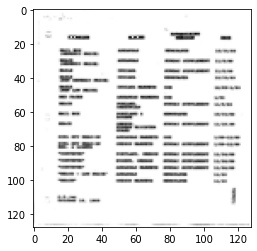

In [50]:
visualise(200)

In [15]:
approximation = pca.inverse_transform(reducedDataset)

In [20]:
G = len(np.unique(k_means_labels)) #Number of labels

cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means_labels,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue

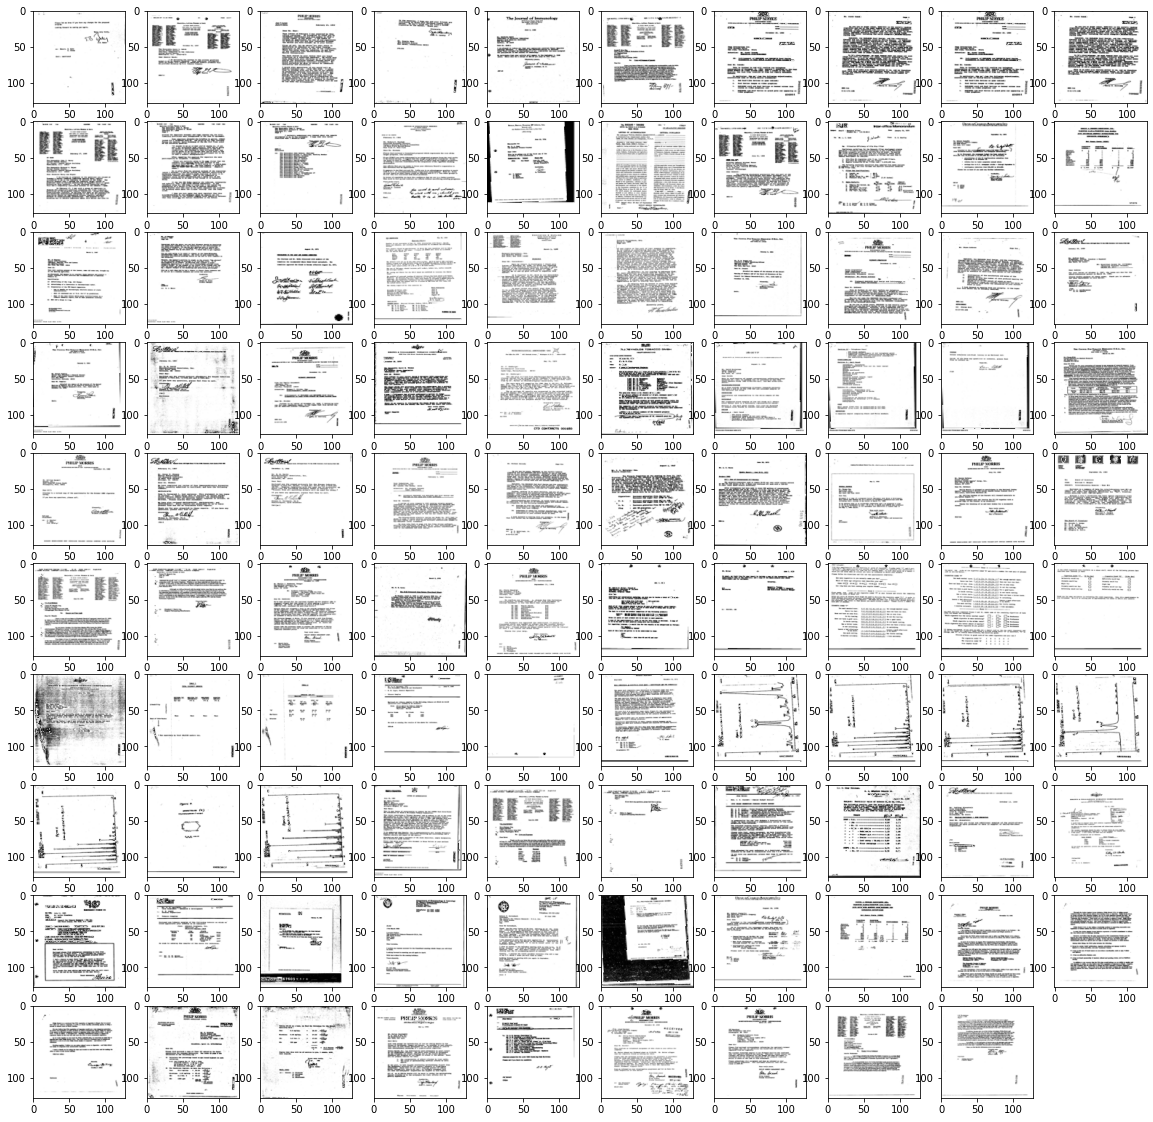

In [43]:
plt.figure(figsize=(20,20));
clust = 3 #enter label number to visualise
num = 100 #num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    #plt.imshow(return_im(i), cmap = plt.cm.binary);
    plt.imshow((return_im(i) * 255).astype(np.uint8))
plt.show()

# Exploring Embedding Clustering with TSNE & HDBSCAN Clustering

In [52]:
import hdbscan
from sklearn.manifold import TSNE

We project to the 98% variance features from the previous PCA calculation

In [ ]:
projection_modelling = TSNE(338, method='exact').fit_transform(output)

In [ ]:
projection_visualisation = TSNE(2).fit_transform(output)

In [ ]:
clusterer = hdbscan.HDBSCAN().fit(projection_modelling)

In [ ]:
len(clusterer.labels_)

In [ ]:
clusterer.labels_.max()

19

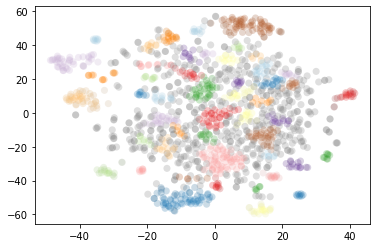

In [ ]:
color_palette = sns.color_palette('Paired', clusterer.labels_.max()+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection_visualisation.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True).fit(output_80)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
projection = TSNE().fit_transform(output)
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

NameError: name 'output_80' is not defined

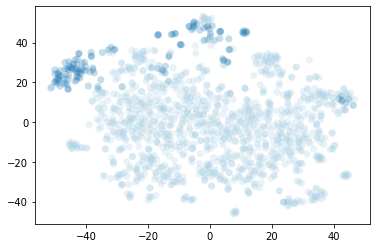

In [ ]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)